In [1]:
import pandas as p
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np


class DataFilter:
    def __init__(self, path):
        '''
        #Parameters:
            path: path of the csv file
        '''
        self.__path = path
        self.__data = p.read_csv(self.__path, delimiter=',')
        self.__alternative_data()
        self.__pre_process_data()
        self.__pre_process_week_data()

        
    def __alternative_data(self):
        # Copying the data before process it
        self.__alternative_data = self.__data.copy()
        
        #Reduce the hour and the day of the alternative data (originally it was the csv data)
        #to get only the number of the day, the day itself and the hour when the car was parked
        self.__alternative_data = self.__reduce_hour(self.__alternative_data)
        self.__alternative_data = self.__reduce_day(self.__alternative_data)
        
        #Delete patente because we wont use it
        #self.__alternative_data.drop(['patente'], axis=1, inplace=True)
        
        
    def __pre_process_data(self):
        '''
        Private method where the data is preprocessed
        '''
        #Delete 'Salida' cause we dont want repeated data (noise)
        self.__preprocessed_data = self.__data.loc[self.__data.operacion == 'Entrada', ['id_cuadra','fecha','hora']]
        
        #Only because the default is to raise an error for the copy, and we are copying...
        p.options.mode.chained_assignment = None  # default='warn'
        
        #Getting the hour of the operations
        self.__reduce_hour(self.__preprocessed_data)
        
        #Create a new column called dia and assign to it an int for each day (Monday: 0,..., Sunday: 6)
        self.__preprocessed_data['dia'] = self.__preprocessed_data['fecha'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday()) # get the weekday index, between 0 and 6
        
        #Change column 'dia' values for the name of each day
        self.__preprocessed_data['dia'] = self.__preprocessed_data['dia'].apply(lambda x: calendar.day_name[x])
        
        #Delete the sundays, cause the parking system is free that day
        self.__preprocessed_data = self.__preprocessed_data.loc[self.__preprocessed_data.dia != 'Sunday']
    
    def __pre_process_week_data(self):
        '''
        Private method where the week data is preprocessed
        '''
        self.__week_data = self.__preprocessed_data.groupby(['id_cuadra','fecha','dia','hora']).size()
        self.__week_data = self.__rename_column(self.__week_data, 0, 'cantidad estacionados')
        
    
    def __reduce_hour(self, df):
        df.hora = p.to_datetime(df.hora)
        df['tiempo'] = df.hora.dt.time
        df.hora = df.hora.dt.hour
        return df
    
    def __reduce_day(self, df):
        #Create a new column called dia(num) and assign to it an int for each day (Monday: 0,..., Sunday: 6)
        df['dia(num)'] = df['fecha'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday()) # get the weekday index, between 0 and 6
        
        #Change column 'dia' values for the name of each day
        df['dia'] = df['dia(num)'].apply(lambda x: calendar.day_name[x])
        
        return df
                
    def __rename_column(self, no_df, column_old_name, column_new_name):
        '''
        Private method whos convert series or groupbydf 
        to DataFrame
        
        # Parameters:
            no_df: the series or groupbydf to convert
            column_name: the name of the column to change
            column_name: the name of the column
        '''
        if isinstance(no_df, p.DataFrame):
            out = no_df
        else:
            out = no_df.to_frame()
        out = out.reset_index()
        out = out.rename(columns = {column_old_name: column_new_name})
        return out
    
    def get_csv_data(self):
        '''
        Returns raw data extracted from the csv file
        '''
        return self.__data
    
    def get_alternative_data(self):
        '''
        Returns another pre processed version of the data, this could be
        the second version (after seeing that i will need another pre processing
        algorithm)
        '''
        return self.__alternative_data
    
    def get_week_data(self):
        '''
        Returns the week data
        '''
        return self.__week_data
    
    
    def get_week_data_avg(self, street):
        '''
        Returns a DataFrame with the average parked 
        cars at every day of the week
        
        #Parameters:
            street: street on wich you want the data
        '''   
        #Getting only the values of the selected streets
        selected_street_mean = self.__week_data.loc[self.__week_data.id_cuadra == street, ['dia','cantidad estacionados']]
        
        #The mean of the parked cars on each day. Hour doesn't matters 
        
        selected_street_mean = selected_street_mean.groupby(['dia']).mean()
        selected_street_mean = self.__rename_column(selected_street_mean, 'cantidad estacionados', 'promedio cantidad estacionados')
        selected_street_mean = self.__sort_by_weekday(selected_street_mean)
        
        return selected_street_mean
        
        
    def get_week_data_std(self, street):
        '''
        Returns a DataFrame with the standard deviation 
        of the average cars parked every day of the week
        
        #Parameters:
            street: street on wich you want the data
        '''
        #Getting only the values of the selected streets
        
        
        selected_street_std = self.__week_data.loc[self.__week_data.id_cuadra == street, ['dia','cantidad estacionados']]
        
        #The standard deviation of the parked cars on each day. Hour doesn't matters
                
        selected_street_std = selected_street_std.groupby(['dia']).std()
        selected_street_std = self.__rename_column(selected_street_std, 'cantidad estacionados', 'desvio cantidad estacionados')
        selected_street_std = self.__sort_by_weekday(selected_street_std, new_column_name='desvio cantidad estacionados')
        
        return selected_street_std
    
    
    def get_day_data_avg(self, street, day):
        '''
        Returns a DataFrame with the average cars 
        parked every hour of the day in a designated street
        
        #Parameters:
            street: street on wich you want the data
            day: day of the week on wich you want the data
        '''
        #Getting only the values of the selected street and day
        day_data = self.__preprocessed_data.loc[(self.__preprocessed_data.id_cuadra == street) & (self.__preprocessed_data.dia == day)]
        
        #The mean of the parked cars each hour of a day
        day_data = day_data.groupby(['fecha', 'hora','dia']).size()
        day_data = self.__rename_column(day_data, 0, 'cantidad estacionados')

        day_data = day_data.groupby(['hora']).mean()
        day_data = self.__rename_column(day_data, 'cantidad estacionados', 'promedio cantidad estacionados')

        #day_data = day_data.loc[['hora','promedio cantidad estacionados']]
        return day_data

    
    def get_day_data_std(self, street, day):
        '''
        Returns a DataFrame with the average cars 
        parked every hour of the day in a designated street
        
        #Parameters:
            street: street on wich you want the data
            day: day of the week on wich you want the data
        '''
        #Getting only the values of the selected street and day
        day_data = self.__preprocessed_data.loc[(self.__preprocessed_data.id_cuadra == street) & (self.__preprocessed_data.dia == day)]
        
        #The mean of the parked cars each hour of a day
        day_data = day_data.groupby(['fecha', 'hora','dia']).size()
        day_data = self.__rename_column(day_data, 0, 'cantidad estacionados')

        day_data = day_data.groupby(['hora']).std()
        day_data = self.__rename_column(day_data, 'cantidad estacionados', 'desvio cantidad estacionados')
        #day_data = day_data.loc[['hora','desvio cantidad estacionados']]
        return day_data
    
    
    def plot_week_full_data(self, street):
        '''
        Plot a bar graph with the average cars parked
        every day of the week with their standard deviation
        
        #Parameters:
            street: street on wich you want the plot
        '''
        #To make a fancy graph
        plt.style.use('ggplot')
        plt.rcParams['figure.figsize'] = (10,6)
        
        #Obtaining the mean and the std data to plot
        selected_street_mean = self.get_week_data_avg(street)
        selected_street_std = self.get_week_data_std(street)
        
        #Getting the days in order
        daysOfTheWeek = selected_street_mean['dia']
        x_pos = [i for i, _ in enumerate(daysOfTheWeek)]

        #Plotting
        plt.bar(x_pos, selected_street_mean['promedio cantidad estacionados'], color='green')
        plt.errorbar(x_pos, selected_street_mean['promedio cantidad estacionados'], selected_street_std['desvio cantidad estacionados'], linestyle='None', color='red')
        plt.xlabel("Days of the week")
        plt.ylabel("Average parked cars")
        plt.title("Parked cars by days in street nº{}".format(street))
        plt.xticks(x_pos, daysOfTheWeek)
        plt.show()

        
    def plot_day_full_data(self, street, day):
        '''
        Plot a line graph with the average cars parked 
        every hour of the day in a designated street
        
        #Parameters:
            street: street on wich you want the plot
            day: day of the week on wich you want the plot
        '''
        #To make a fancy graph
        plt.rcParams['figure.figsize'] = (10,4)
        plt.style.use('ggplot')
        starter_hour, finish_hour = 8, 20
        time = np.linspace(starter_hour, finish_hour, 200) #200 represents number of points to make between T.min and T.max

        #Obtaining the mean and the std data to plot
        day_std = self.get_day_data_avg(street, day)
        day_deviation = self.get_day_data_std(street, day)
        
        #Plotting
        self.__plot_day_graph(street, day, day_std, day_deviation, time)
        
        
    def __plot_day_graph(self, street, day, day_std, day_deviation, time): 
        '''
        Plot the graph of the selected day
        '''        
        plt.xlabel("Hours of the day")
        plt.ylabel("Average parked cars")
        plt.title("Parked cars by hour in street nº{} on {}".format(street, day))    
        plot = make_interp_spline(day_std.hora, day_std['promedio cantidad estacionados'], k=2)(time) #BSpline object
        
        #Only because I want all graphs to have the same size
        fake_data = day_std.copy()
        fake_data['promedio cantidad estacionados'] = 12
        fake_plot = make_interp_spline(fake_data.hora, fake_data['promedio cantidad estacionados'], k=1)(time) #BSpline object
        plt.plot(time, fake_plot, alpha=0.0)
        
        #Plotting the bar graph
        plt.plot(time, plot)
        
        #Plotting the standard deviation        
        plt.fill_between(day_std.hora, day_std['promedio cantidad estacionados']-day_deviation['desvio cantidad estacionados'], day_std['promedio cantidad estacionados']+day_deviation['desvio cantidad estacionados'],alpha=.1)

        plt.show()

        
    def __sort_by_weekday(self, values, new_column_name='promedio cantidad estacionados'):
        '''
        Sort values by weekday
        '''
        days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
        mapping = {day: i for i, day in enumerate(days)}
        key = values['dia'].map(mapping)
        out = values.iloc[key.argsort()].set_index('dia')
        out = self.__rename_column(out, 0, new_column_name)
        return out
    
    
    def get_free_streets_v1(self, day, hour):
        '''
        v1 - P(Free_spot) = 1 - AVG/SUM(AVGs)
        
        Returns a DataFrame containing the street, the average parked
        cars and the free streets in Tandil, in descendent order
        (the higher the value, the higher posibility of a free spot in 
        that street).
        
        Parameters:
            day: day of the week on wich you want the data
            hour: the hour of the day on wich you want the data 
        '''
        
        #Create the out df with the columns indexes
        out = p.DataFrame({'id_calle':[], 'promedio cantidad estacionados': []})
        
        #Get all the streets an iterate over them
        all_streets = self.get_csv_data()['id_cuadra'].max() + 1
        for street in range(1, all_streets):
            street_data = self.get_day_data_avg(street=street, day=day)
            street_data = street_data.loc[street_data.hora == hour, ['promedio cantidad estacionados']]
            if street_data.empty == False:
                #If the row contains a value for that day and hour, we append that value
                #to the out df 
                out.loc[street] = [street, street_data['promedio cantidad estacionados'].to_string(index=False)]
        
        #Convert the columns values to their respective type
        out['id_calle'] = out['id_calle'].astype(int)
        out['promedio cantidad estacionados'] = out['promedio cantidad estacionados'].astype(float)
        
        #Calculate: P(Ocuppied)   = AVG/SUM
        #           P(Free_spot) = 1 - P(Ocuppied)
        total_sum = out['promedio cantidad estacionados'].sum()
        out['probabilidad de encontrar estacionamiento'] = 1 - out['promedio cantidad estacionados'].div(total_sum)
        
        #Sort the values by their P(Free_spot) in descendent order
        return out.sort_values(by='probabilidad de encontrar estacionamiento', ascending=False)
    
    def get_free_streets_v2(self, day, hour):
        '''
        v2 - P(Free_spot) = 1 - AVG/MAX_PARKED(street)
        
        Returns a DataFrame containing the street, the average parked
        cars and the free streets in Tandil, in descendent order
        (the higher the value, the higher posibility of a free spot in 
        that street).
        
        Parameters:
            day: day of the week on wich you want the data
            hour: the hour of the day on wich you want the data 
        '''
        #Create the out df with the columns indexes
        out = p.DataFrame({'id_calle':[], 'probabilidad de encontrar lugar libre': []})
        
        #Get all the streets an iterate over them
        all_streets = self.get_csv_data()['id_cuadra'].max() + 1
        for street in range(1, all_streets):
            street_data = self.get_day_data_avg(street=street, day=day)
            street_data = street_data.loc[street_data.hora == hour, ['promedio cantidad estacionados']]
            if street_data.empty == False:                
                value = street_data['promedio cantidad estacionados'].to_string(index=False)
                value = float(value)
                max_value = self.get_max_value(street)
                value = value / max_value
                value = 1 - value
                #print(value)
                out.loc[street] = [street, value]
        
        #Convert the columns values to their respective type
        out['id_calle'] = out['id_calle'].astype(int)
        #out['probabilidad de encontrar lugar libre'] = out['probabilidad de encontrar lugar libre'].astype(float)
        return out.sort_values(by='probabilidad de encontrar lugar libre', ascending=False)
                
    def get_max_value(self, street):
        '''
        Returns the max parked cars ever in street.
        
        Parameters:
                street: street on wich you want the data
        '''
        #Getting only the values of the selected street
        day_data = self.__preprocessed_data.loc[(self.__preprocessed_data.id_cuadra == street)]
        
        #The max of the parked cars in a street
        day_data = day_data.groupby(['fecha', 'hora','dia']).size()
        day_data = self.__rename_column(day_data, 0, 'cantidad estacionados')

        return day_data['cantidad estacionados'].max()

In [2]:
dataFilter = DataFilter(r"C:\Users\ing_l\Desktop\Facultad\Tesis\Data\Data 1\BD_Parking.csv")

In [3]:
dataFilter.get_csv_data()

,id_cuadra,operacion,patente,tarjeta,fecha,hora
0,82,Entrada,BVQ775,10037637,2018-01-01,07:11:00
1,40,Entrada,DCN224,10059452,2018-01-01,11:26:00
2,61,Entrada,ATE568,10032179,2018-01-01,13:09:00
3,34,Entrada,LPV400,10026609,2018-01-01,16:53:00
4,66,Entrada,FMR105,10073847,2018-01-01,17:25:00
5,16,Entrada,FCR161,10012270,2018-01-01,18:11:00
6,34,Entrada,GJQ120,10124912,2018-01-01,18:38:00
7,12,Entrada,FKE897,10161964,2018-01-01,19:47:00
8,47,Entrada,FCE602,10136782,2018-01-01,21:05:00
9,47,Entrada,FCE602,10136782,2018-01-01,21:06:00


In [4]:
dataFilter.get_week_data()

,id_cuadra,fecha,dia,hora,cantidad estacionados
0,1,2018-05-02,Wednesday,17,2
1,2,2018-01-02,Tuesday,7,1
2,2,2018-01-02,Tuesday,8,3
3,2,2018-01-02,Tuesday,9,6
4,2,2018-01-02,Tuesday,10,6
5,2,2018-01-02,Tuesday,11,7
6,2,2018-01-02,Tuesday,12,13
7,2,2018-01-02,Tuesday,13,5
8,2,2018-01-02,Tuesday,14,8
9,2,2018-01-02,Tuesday,15,4


In [5]:
dataFilter.get_week_data_avg(street=10)

,dia,promedio cantidad estacionados
0,Monday,4.731278
1,Tuesday,4.556452
2,Wednesday,4.779116
3,Thursday,4.583658
4,Friday,4.602564
5,Saturday,3.241667


In [6]:
dataFilter.get_week_data_std(street=10)

,dia,desvio cantidad estacionados
0,Monday,2.587075
1,Tuesday,2.902749
2,Wednesday,2.980347
3,Thursday,2.835635
4,Friday,2.540689
5,Saturday,2.300880


In [7]:
dataFilter.get_day_data_avg(street=10, day='Monday')

,hora,promedio cantidad estacionados
0,8,1.285714
1,9,3.789474
2,10,7.380952
3,11,5.842105
4,12,5.650000
5,13,4.736842
6,14,4.631579
7,15,2.944444
8,16,4.736842
9,17,5.100000


In [8]:
dataFilter.get_day_data_std(street=10, day='Monday')

,hora,desvio cantidad estacionados
0,8,0.487950
1,9,1.902599
2,10,2.558832
3,11,2.630234
4,12,2.539685
5,13,2.104020
6,14,2.191157
7,15,2.099642
8,16,2.445906
9,17,2.268781


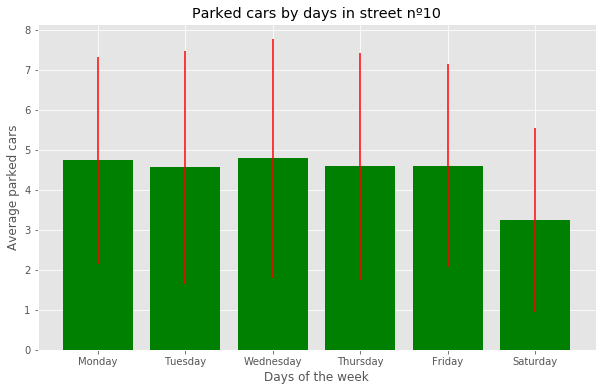

In [9]:
dataFilter.plot_week_full_data(street=10)

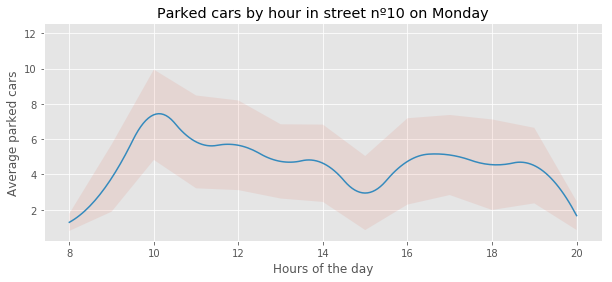

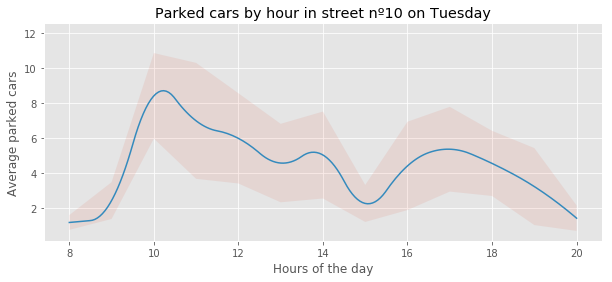

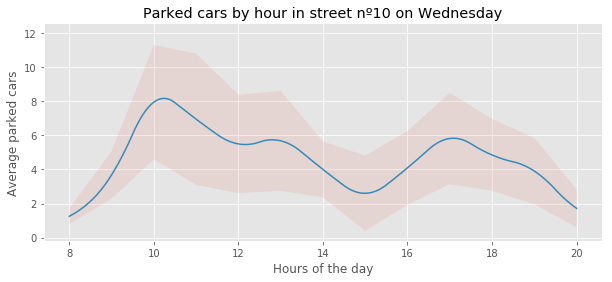

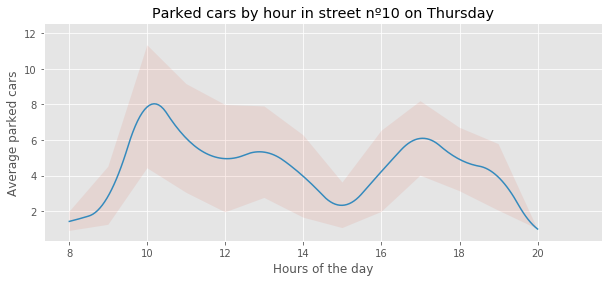

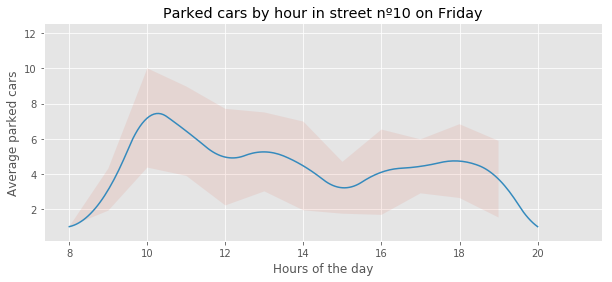

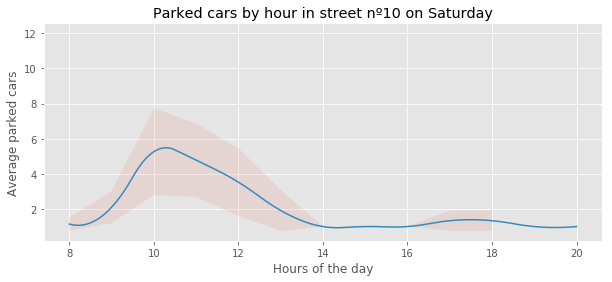

In [10]:
dataFilter.plot_day_full_data(street=10, day='Monday')
dataFilter.plot_day_full_data(street=10, day='Tuesday')
dataFilter.plot_day_full_data(street=10, day='Wednesday')
dataFilter.plot_day_full_data(street=10, day='Thursday')
dataFilter.plot_day_full_data(street=10, day='Friday')
dataFilter.plot_day_full_data(street=10, day='Saturday')

In [11]:
dataFilter.get_free_streets_v1(day='Monday', hour=10)

,id_calle,promedio cantidad estacionados,probabilidad de encontrar estacionamiento
78,78,1.454545,0.997429
92,92,1.500000,0.997348
71,71,1.500000,0.997348
85,85,1.571429,0.997222
87,87,2.062500,0.996354
40,40,2.117647,0.996257
86,86,2.142857,0.996212
70,70,2.400000,0.995757
50,50,2.526316,0.995534
69,69,2.578947,0.995441


In [12]:
dataFilter.get_free_streets_v2(day='Monday', hour=10)

,id_calle,probabilidad de encontrar lugar libre
40,40,0.764706
71,71,0.750000
87,87,0.742188
85,85,0.738095
84,84,0.723077
78,78,0.709091
54,54,0.700000
3,3,0.697368
86,86,0.693878
60,60,0.691667


## Alternative data test
Alternative data set is the same data set but with other processing of their data.

Now we want to get the trusted data. That is the data when the car is marked as "Entrada" in a street
and as "Salida" en the same street.

The reason of that reasoning is to set free from noise our dataset. 

We can (not 100% acc) say that the car was parked in the street with that id.

In [13]:
alternative_data = dataFilter.get_alternative_data()
alternative_data

,id_cuadra,operacion,patente,tarjeta,fecha,hora,tiempo,dia(num),dia
0,82,Entrada,BVQ775,10037637,2018-01-01,7,07:11:00,0,Monday
1,40,Entrada,DCN224,10059452,2018-01-01,11,11:26:00,0,Monday
2,61,Entrada,ATE568,10032179,2018-01-01,13,13:09:00,0,Monday
3,34,Entrada,LPV400,10026609,2018-01-01,16,16:53:00,0,Monday
4,66,Entrada,FMR105,10073847,2018-01-01,17,17:25:00,0,Monday
5,16,Entrada,FCR161,10012270,2018-01-01,18,18:11:00,0,Monday
6,34,Entrada,GJQ120,10124912,2018-01-01,18,18:38:00,0,Monday
7,12,Entrada,FKE897,10161964,2018-01-01,19,19:47:00,0,Monday
8,47,Entrada,FCE602,10136782,2018-01-01,21,21:05:00,0,Monday
9,47,Entrada,FCE602,10136782,2018-01-01,21,21:06:00,0,Monday


In [14]:
#Sorting the values so we can see easely the data structure and the trusted values

alternative_data = alternative_data.sort_values(['tarjeta','fecha','tiempo']).reset_index(drop=True)

alternative_data

,id_cuadra,operacion,patente,tarjeta,fecha,hora,tiempo,dia(num),dia
0,86,Entrada,KID966,10000001,2018-01-04,18,18:29:00,3,Thursday
1,86,Salida,KID966,10000001,2018-01-04,18,18:33:00,3,Thursday
2,69,Entrada,KID966,10000001,2018-01-05,17,17:58:00,4,Friday
3,69,Salida,KID966,10000001,2018-01-05,18,18:26:00,4,Friday
4,17,Entrada,KID966,10000001,2018-01-09,17,17:53:00,1,Tuesday
5,17,Salida,KID966,10000001,2018-01-09,18,18:09:00,1,Tuesday
6,24,Entrada,KID966,10000001,2018-01-19,18,18:29:00,4,Friday
7,24,Salida,KID966,10000001,2018-01-19,19,19:11:00,4,Friday
8,69,Entrada,KID966,10000001,2018-03-06,18,18:03:00,1,Tuesday
9,69,Salida,KID966,10000001,2018-03-06,18,18:19:00,1,Tuesday


In [15]:
#Now that we have just sorted the data, we need to look at one row
#and the next one that. If they have the same id_cuadra and the first
#have the value "Entrada" and the second one have the value "Salida"
#we will say that they are trusted values that are OK to use in the 
#dataset for our model


alternative_data['valores confiables'] = 


#print(alternative_data.iloc[index_entrada])

#print(alternative_data.iloc[index_entrada]['id_cuadra'] == alternative_data.iloc[index_salida]['id_cuadra'])

'''
#Create a new column called valores confiables
alternative_data['valores confiables'] = p.Series(np.zeros(len(alternative_data.id_cuadra)), index=alternative_data.index)

max_len = int(len(alternative_data)/2)

#Gettin the even and the odd rows
first_part = alternative_data[::2].reset_index(drop=True)
second_part = alternative_data[1::2].reset_index(drop=True)

#Limiting its size to the max of both cause we need to compare them 
first_part = first_part[:max_len:]
second_part = second_part[:max_len:]

print(first_part.index)
print(second_part.index)

#Compare if id_cuadra is the same for both (the first row and the second, e.g. for the entrada-salida values)
first_comparison = (first_part[::]['id_cuadra'] == second_part[::]['id_cuadra']).reset_index(drop=True)

#Compare if both operacion are differents (one is entrada and the other is salida)
second_comparison = (first_part[::]['operacion'] != second_part[::]['operacion']).reset_index(drop=True)

#print((first_comparison & second_comparison).to_frame())

#new_index = ([x*2 for x in range(len(first_comparison))])

full_comparison = (first_comparison & second_comparison).to_frame()

alternative_data_2 = alternative_data[::2].reset_index(drop=True)

alternative_data_2['valores confiables'] = full_comparison

print(alternative_data_2)

#ESTOY TENIENDO PROBLEMAS CON LOS TRUE Y LOS FALSE, NO SE ACOMODAN A DONDE DEBERIAN DE IR.
#LA IDEA ES QUE VAYAN INTERCALADOS LOS TRUE Y LOS FALSE EN EL DATAFRAME PERO NO ESTARIA 
#PASANDO ESO, CUANDO PASA LOS 375.000 APROX SE PONEN TODOS NaN, NO SE POR QUE

#print(alternative_data)

'''

SyntaxError: invalid syntax (<ipython-input-15-8abf8a7e68d6>, line 8)

In [ ]:
alternative_data

In [ ]:
#The values that we cant trust

alternative_data.loc[alternative_data['valores confiables'].isna()]

In [ ]:
print(first_comparison[int(352376/2-5):int(352376/2+5)])

In [ ]:
alternative_data[352370:]

# Data scraper

In [23]:
import urllib.request
from bs4 import BeautifulSoup
import json

#Obtain the acces to the html
html = urllib.request.urlopen('http://gpssumo.com/parquimetros/get_PA/codigo')
#Extract the text from the html
data = BeautifulSoup(html, 'lxml').text

In [24]:
#Replace all the ' for " cause the json cant have '
jsoned_data = data.replace('\'',"\"")
#Convert string data to json 
json_data = json.loads(jsoned_data)

In [38]:
original_data = dataFilter.get_csv_data()
original_data['direccion'] = 0
for d in json_data:
    print(d['id_cuadra'])
    original_data.loc[original_data.id_cuadra == d['id_cuadra'], 'direccion'] = d['direccion']

22
2
3


C:\Users\ing_l\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


4
5
6
7
8
9
10
11
12
13
14
15
16
17
34
19
20
21
28
32
36
23
47
44
43
24
45
48
30
33
29
31
49
25
50
57
27
46
35
38
26
41
39
40
37
42
52
53
54
71
51
55
60
56
62
59
63
61
58
74
70
72
64
67
66
65
73
69
68
80
82
77
84
81
78
83
75
79
76
86
88
87
91
85
90
89
99
98
97
96
95
94
93
92


In [37]:
original_data

,id_cuadra,operacion,patente,tarjeta,fecha,hora,"(False, direccion)",direccion
0,82,Entrada,BVQ775,10037637,2018-01-01,07:11:00,Tribunal de Faltas,0
1,40,Entrada,DCN224,10059452,2018-01-01,11:26:00,Tribunal de Faltas,0
2,61,Entrada,ATE568,10032179,2018-01-01,13:09:00,Tribunal de Faltas,0
3,34,Entrada,LPV400,10026609,2018-01-01,16:53:00,Tribunal de Faltas,0
4,66,Entrada,FMR105,10073847,2018-01-01,17:25:00,Tribunal de Faltas,0
5,16,Entrada,FCR161,10012270,2018-01-01,18:11:00,Tribunal de Faltas,0
6,34,Entrada,GJQ120,10124912,2018-01-01,18:38:00,Tribunal de Faltas,0
7,12,Entrada,FKE897,10161964,2018-01-01,19:47:00,Tribunal de Faltas,0
8,47,Entrada,FCE602,10136782,2018-01-01,21:05:00,Tribunal de Faltas,0
9,47,Entrada,FCE602,10136782,2018-01-01,21:06:00,Tribunal de Faltas,0
